# Importing Libraries







in this part we will install all the necessary libraries on command prompt and then import the necessary functions from those libraries. 

In [1]:
# importing all the necessary libraries







import pandas as pd















from numpy import mean







import numpy as np







import time















# step 1: preprocessing







from sklearn.impute import SimpleImputer # import some strategic imputer to fill in any missing values using mean







from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, Normalizer # scale all the values to one range to avoid any biasness (this bias is seen in mostly naive bayes and knn etc)















from sklearn.impute import KNNImputer # import some strategic imputer to fill missing values using KNN (finds the nearest neighbour and fills it with that value)















from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, f_classif, VarianceThreshold, f_regression















from sklearn.decomposition import PCA







from sklearn.compose import ColumnTransformer







from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder







from sklearn.pipeline import Pipeline







from sklearn.linear_model import Ridge, Lasso















# step 2: data division







from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, GridSearchCV, ParameterGrid # to divide the code into train/test using a specific percentage or with/without replacement















# step 3: model







from sklearn.ensemble import GradientBoostingRegressor















# step 4: displaying accuracy







from sklearn.metrics import roc_auc_score, accuracy_score # to display the accuracy of our tree







from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer















# step 5: warning filter







import warnings







warnings.filterwarnings('ignore')

In [2]:
import sklearn







print(sklearn.__version__)

1.2.2


In [3]:
# pip install --upgrade scikit-learn

# Data Loading







data shall be loaded into variables as data sets using pandas and csv readers. they will be checked to see if they are loaded properly and will be loaded as 2 sets: train and test as per given in the kaggle data

In [4]:
# lets load the training data set







train_data = pd.read_csv(r"/kaggle/input/challenge2/train.csv")

# train_data = pd.read_csv(r"D:\Users\DELL\OneDrive - Institute of Business Administration\IBA\sem5\machine learning\ipynb notebooks\challenger2\iml-fall-2024-challenge-2\train\train.csv")













# lets also check it by getting the first few rows of the data, there should be x1 - x78 and one target variable Y







train_data.head() 

,full_sq,life_sq,floor,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,43.0,27.0,4.0,Investment,Bibirevo,6407578.100,155572.0,0.189727,0.000070,9576.0,...,9.0,4.0,0.0,13.0,22.0,1.0,0.0,52.0,4.0,5850000.0
1,34.0,19.0,3.0,Investment,Nagatinskij Zaton,9589336.912,115352.0,0.372602,0.049637,6880.0,...,15.0,3.0,0.0,15.0,29.0,1.0,10.0,66.0,14.0,6000000.0
2,43.0,29.0,2.0,Investment,Tekstil'shhiki,4808269.831,101708.0,0.112560,0.118537,5879.0,...,10.0,3.0,0.0,11.0,27.0,0.0,4.0,67.0,10.0,5700000.0
3,77.0,77.0,4.0,Investment,Basmannoe,8398460.622,108171.0,0.015234,0.037316,5706.0,...,319.0,108.0,17.0,135.0,236.0,2.0,91.0,195.0,14.0,16331452.0
4,67.0,46.0,14.0,Investment,Nizhegorodskoe,7506452.020,43795.0,0.007670,0.486246,2418.0,...,62.0,14.0,1.0,53.0,78.0,1.0,20.0,113.0,17.0,9100000.0


In [5]:
# lets load the test data







test_data = pd.read_csv(r"/kaggle/input/challenge2/test.csv")

# test_data = pd.read_csv(r"D:\Users\DELL\OneDrive - Institute of Business Administration\IBA\sem5\machine learning\ipynb notebooks\challenger2\iml-fall-2024-challenge-2\test\test.csv")









# check if the data has been loaded by getting the first 5 rows - there should be x1 - x78 and no target variable Y as this is test data







test_data.head() 

,row ID,full_sq,life_sq,floor,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
0,Row3,89.0,50.0,9.0,Investment,Mitino,1.258354e+07,178473.0,0.194703,0.069753,...,15.0,11.0,2.0,1.0,4.0,4.0,0.0,0.0,26.0,3.0
1,Row6,25.0,14.0,10.0,Investment,Sokol'niki,1.032047e+07,57405.0,0.523439,0.042307,...,144.0,81.0,16.0,3.0,38.0,80.0,1.0,27.0,127.0,8.0
2,Row11,38.0,19.0,11.0,Investment,Zapadnoe Degunino,7.632940e+06,78810.0,0.051844,0.437885,...,39.0,8.0,3.0,0.0,10.0,9.0,0.0,0.0,35.0,4.0
3,Row12,43.0,28.0,4.0,Investment,Kuncevo,5.235177e+07,142462.0,0.070662,0.035145,...,21.0,13.0,9.0,1.0,7.0,15.0,0.0,2.0,47.0,0.0
4,Row14,31.0,21.0,3.0,Investment,Lefortovo,8.993640e+06,89971.0,0.066941,0.306977,...,205.0,88.0,19.0,2.0,63.0,100.0,0.0,28.0,132.0,14.0


# Data Preprocessing







before we start processing this data and using algorithms, we will fix this data first, this is called data preprocessing

## split data into categorical and numerical







categorical will have one-hot and simple imputer of most frequent while numerical will have simple mean imputer and minmax scaler

In [6]:
categorical_cols = train_data.select_dtypes(include=["object"]).columns







numerical_cols = train_data.select_dtypes(exclude=["object"]).drop(columns=['price_doc']).columns

# Imputers

In [7]:
num_imputer = SimpleImputer(strategy="mean")



train_data[numerical_cols] = num_imputer.fit_transform(train_data[numerical_cols])



test_data[numerical_cols] = num_imputer.transform(test_data[numerical_cols])







cat_imputer = SimpleImputer(strategy="most_frequent")



train_data[categorical_cols] = cat_imputer.fit_transform(train_data[categorical_cols])



test_data[categorical_cols] = cat_imputer.transform(test_data[categorical_cols])

# Scaler

In [8]:
scaler = MinMaxScaler()



train_data[numerical_cols] = scaler.fit_transform(train_data[numerical_cols])



test_data[numerical_cols] = scaler.transform(test_data[numerical_cols])

# One hot

In [9]:
train_data = pd.get_dummies(train_data, columns=categorical_cols, drop_first=True)



test_data = pd.get_dummies(test_data, columns=categorical_cols, drop_first=True)



# Align the test data with the training data columns



test_data = test_data.reindex(columns=train_data.columns, fill_value=0)







# test_data = test_data.drop(columns=['price_doc'], errors="ignore")

## correlation matrix







i tried getting the correlation matrix but apparently a 2000 columns matrix is very computationally expensive as it performs pairs for all. so dont run it. it takes too long and then fails. i ran for 5 minutes. 

In [10]:
# # DONT RUN







# corr_matrix = train_data.corr()







# print(corr_matrix)

# variance

In [11]:
train_features = train_data.drop(columns=['price_doc'])

feature_variances = train_features.var(axis=0)



print(feature_variances.describe())

count    2199.000000
mean        0.007445
std         0.020317
min         0.000011
25%         0.000055
50%         0.000083
75%         0.000160
max         0.239073
dtype: float64


In [12]:
from sklearn.feature_selection import VarianceThreshold







selector = VarianceThreshold(threshold=0.001) 



train_features_reduced = selector.fit_transform(train_features)



print(train_features_reduced)



print(train_features_reduced.shape)







# test_features = selector.transform(test_data)

[[0.0080736  0.00361059 0.05194898 ... 0.         0.         0.        ]
 [0.00638378 0.00254079 0.03896173 ... 0.         0.         0.        ]
 [0.0080736  0.00387804 0.02597449 ... 0.         1.         0.        ]
 ...
 [0.00901239 0.00441294 0.03896173 ... 1.         0.         0.        ]
 [0.00901239 0.00441294 0.03896173 ... 1.         0.         0.        ]
 [0.00901239 0.00441294 0.03896173 ... 1.         0.         0.        ]]
(181507, 419)


# PCA







principal component analysis is applied

Cumulative explained variance:  [0.33608176 0.45078765 0.50827733 0.52889437 0.54472625 0.55902962
 0.57175488 0.58313326 0.59326414 0.60298062 0.61205016 0.62062444
 0.62865357 0.63590572 0.64246168 0.6485632  0.65446394 0.6601697
 0.6657632  0.67109076 0.67607886 0.68080734 0.68547704 0.68978843
 0.69398899 0.69811994 0.70221196 0.70610316 0.70981519 0.71342876
 0.71690307 0.72030681 0.72365901 0.72692964 0.73001386 0.73299357
 0.73580613 0.73848754 0.74107348 0.74357633 0.74597666 0.74826115
 0.75048746 0.75266683 0.7548272  0.75691283 0.75896818 0.76095917
 0.76289422 0.76473649 0.76652538 0.76828728 0.7700219  0.77167889
 0.77332254 0.77494689 0.77650594 0.77804545 0.7795347  0.78099808
 0.78241464 0.78381995 0.78521309 0.78658344 0.78794172 0.7892677
 0.79054433 0.79181731 0.79306954 0.7943066  0.79552865 0.79674463
 0.79793227 0.79911178 0.8002854  0.80144808 0.80259085 0.80372656
 0.80484071 0.80594526 0.80704415 0.80812555 0.80919725 0.8102672
 0.81131764 0.81235756 0.81338574

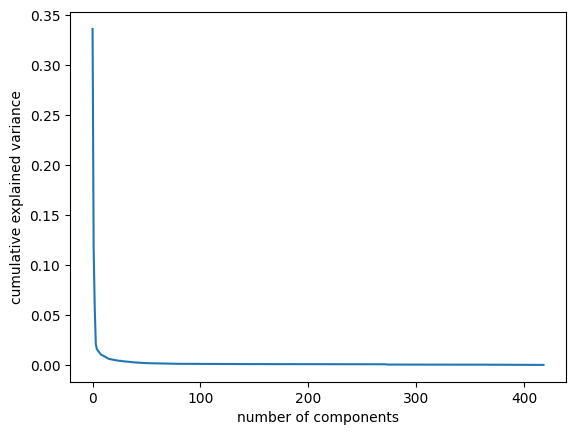

In [13]:
# plot an elbow graph to find the optimal number of components



import matplotlib.pyplot as plt



from sklearn.decomposition import PCA







pca = PCA()



pca.fit(train_features_reduced)  # Fit PCA to your dataset







plt.plot(pca.explained_variance_ratio_)



plt.xlabel('number of components')



plt.ylabel('cumulative explained variance')



pca.explained_variance_ratio_.round(3)



cumulative_variance = np.cumsum(pca.explained_variance_ratio_)



print("Cumulative explained variance: ", cumulative_variance)



print(cumulative_variance)

In [14]:
print("Principal components shape:", pca.components_.shape)



print("Principal components:\n", pca.components_)







# Preserve the target variable



train_copy = train_data.copy()  # Backup original data



test_copy = test_data.copy()







# Separate target variable and features



train_features = train_data.drop(columns=['price_doc'])  # Features for PCA



train_target = train_data['price_doc']                  # Target variable







test_features = test_data.drop(columns=['price_doc'])    # Features for PCA







# Apply PCA transformation



pca = PCA(n_components=0.95)



train_features_pca = pca.fit_transform(train_features)  # Fit and transform train data



print("train transformed")



test_features_pca = pca.transform(test_features)        # Transform test data







print(train_features_pca.shape)



print(test_features_pca.shape)

Principal components shape: (419, 419)
Principal components:
 [[ 7.06535068e-02  6.25408221e-02  5.79405267e-02 ... -1.31263626e-03
  -2.19147000e-02  6.25967882e-03]
 [ 1.50205008e-02  1.86027231e-02  8.87599556e-03 ...  2.17734627e-01
  -1.19800109e-01 -1.96346713e-02]
 [-3.48348101e-02 -2.83256709e-02 -3.36084394e-02 ...  9.76871684e-02
   4.36420111e-02 -7.33248157e-02]
 ...
 [-2.86253808e-03 -7.06966249e-04 -1.31744355e-03 ...  6.46859851e-03
  -3.69007701e-03 -3.00703469e-04]
 [ 1.06661518e-03  7.64414689e-04  1.54974009e-03 ... -8.08234561e-03
   8.43366002e-04  1.42446065e-03]
 [ 2.57974749e-03  1.22216094e-03  1.41024318e-03 ... -3.90738758e-05
   8.17832675e-04  5.88054279e-04]]
train transformed
(181507, 267)
(77789, 267)


In [15]:
# Reconstruct train_data and test_data with PCA-transformed features and target variable



train_data = pd.DataFrame(train_features_pca)



train_data['price_doc'] = train_target.reset_index(drop=True)







test_data = pd.DataFrame(test_features_pca)



test_data['price_doc'] = test_copy['price_doc'].reset_index(drop=True)



print("train shape: ", train_data.shape)



print("test shape: ", test_data.shape)

train shape:  (181507, 268)
test shape:  (77789, 268)


## Data Splitting - festures and targets







the data in train_data set is of x1 - x78 columns (79 variables) and one target variable (Y). we must split that data so that we can perform data preprocessing on the features variables (will be referred to as X).

In [16]:
# so in X, it is ALL the columns EXCEPT the last column known as 'Y' (we can confirm this using the train_data.head() we did earlier) so we must get all columns and DROP only the 'y' column







X = train_data.drop(columns=['price_doc'])







X # lets display X and see what it is now

,0,1,2,3,4,5,6,7,8,9,...,257,258,259,260,261,262,263,264,265,266
0,-1.102957,-0.830170,-1.205671,0.603018,0.683040,0.752873,0.069828,-0.576171,-0.076311,0.268685,...,0.001047,0.007192,-0.009072,-0.034419,0.039749,0.025798,-0.018959,0.013474,-0.012058,0.002513
1,-1.213449,-0.704121,-0.515383,0.144235,0.050278,0.310335,0.298051,0.219452,-0.011154,-0.215708,...,0.042235,-0.023780,-0.003765,-0.037508,-0.016068,0.011552,0.019169,0.016897,-0.027764,0.003545
2,-1.480295,-0.808837,-0.504437,-0.727048,-0.460042,-0.073171,0.043554,0.148689,-0.366601,-0.502495,...,-0.058897,-0.029940,-0.011633,0.014612,0.005689,0.018635,-0.005884,-0.006436,0.027017,0.009818
3,1.980825,-2.830914,1.731182,0.882518,-0.558550,0.226280,-0.268761,-0.775397,0.118198,-0.590821,...,0.013396,0.003379,-0.013542,0.011318,-0.029207,0.042276,0.019761,-0.034107,-0.014548,0.017342
4,-0.988652,-1.130559,0.721607,-1.446864,0.053415,-0.759862,0.858606,-0.386101,-0.377549,-0.691534,...,-0.077668,-0.029688,0.024411,0.016042,0.007934,0.024485,0.022745,0.001834,0.037514,-0.011376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181502,-0.233649,4.169748,0.567373,0.194047,-0.715809,0.415565,-0.282681,-0.222991,-0.273641,0.589468,...,0.022461,0.011688,0.002184,0.024548,-0.014988,0.007809,0.010926,-0.007896,0.012289,0.006662
181503,-0.233649,4.169748,0.567373,0.194047,-0.715809,0.415565,-0.282681,-0.222991,-0.273641,0.589468,...,0.022461,0.011688,0.002184,0.024548,-0.014988,0.007809,0.010926,-0.007896,0.012289,0.006662
181504,-0.233649,4.169748,0.567373,0.194047,-0.715809,0.415565,-0.282681,-0.222991,-0.273641,0.589468,...,0.022461,0.011688,0.002184,0.024548,-0.014988,0.007809,0.010926,-0.007896,0.012289,0.006662
181505,-0.233649,4.169748,0.567373,0.194047,-0.715809,0.415565,-0.282681,-0.222991,-0.273641,0.589468,...,0.022461,0.011688,0.002184,0.024548,-0.014988,0.007809,0.010926,-0.007896,0.012289,0.006662


In [17]:
# so as per our X output, we can see that number of columns in train_data is 79 and number of columns in X is 78 meaning we have successfully performed our removal of target variable







# now to get the target variable alone, we can just get it alone,







Y = train_data['price_doc']







Y # lets see what it is







# as per our Y output, we can see it is of one column and 246k rows which means we have successfully extracted the target variable column

0          5850000.0
1          6000000.0
2          5700000.0
3         16331452.0
4          9100000.0
             ...    
181502     3480000.0
181503     3480000.0
181504     3480000.0
181505     3480000.0
181506     3480000.0
Name: price_doc, Length: 181507, dtype: float64

# Filters







there are two types of filters to filter out columns/features:







- variance filter (a column which has same values throughout the column like all are sunny)







- correlation filter (two columns which are same like weight in kg and weight in pounds)

In [18]:
# print("X : ", X.shape)







# print("test data : ", test_data_processed.shape)

In [19]:
# variance filter







# ----------------------------- case  -----------------------------







# variance_filter = VarianceThreshold(threshold=0.001)  # Adjust the threshold if needed







# X = variance_filter.fit_transform(X)







# test_data_processed = variance_filter.fit_transform(test_data_processed)







X.shape

(181507, 267)

In [20]:
# test_data_processed.shape

In [21]:
# # correlation filter







# # ----------------------------- case  -----------------------------







# corr_matrix = pd.DataFrame(X).corr().abs()







# upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))







# to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]







# X = pd.DataFrame(X).drop(columns=to_drop)







# test_data_processed = pd.DataFrame(test_data_processed).drop(columns=to_drop)







X.shape

(181507, 267)

In [22]:
# test_data_processed.shape

## Data Splitting - train and validate







now our test_data set is of rows with NO target variable whereas the train_data set is WITH target variable.







our rules in machine learning is that we must train half or 70% of the data and then we must check its accuracy using the remaining half or 30% of the data - we can only check accuracy IF we have the answers i.e. the target variable. 







So, what we need to do is, is split the train_data set into 2, by a 70% and 30% ratio. we train the model using the 70% and then test the model using the 30% and then use that model to predict the test_data set.

In [23]:
# holdout method







trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.3, random_state=2)

# functions







here we have defined functions like forward-backward selection, kbest selection & algorithm feature importance

In [24]:
# forward backward selection







def fbselection(direction, sample_model, features, X, trainX, trainY, testX, test_data_processed):







    print("starting")







    selection = SequentialFeatureSelector(sample_model, direction=direction, n_features_to_select=features, scoring='roc_auc')







    return modelSelector(sample_model, selection, X, trainX, trainY, testX, test_data_processed)















def modelSelector(sample_model, selection, X, trainX, trainY, testX, test_data_processed):







    print("start extracting")







    trainX = selection.fit_transform(trainX, trainY)







    print("extracted, transforming")







    testX = selection.transform(testX)                                  # Ensure the test set is transformed similarly







    test_data_processed = selection.transform(test_data_processed)      # test data is also transformed







    X = selection.transform(X)                                          # full data transforming







    print("transformed")







    return sample_model, X, trainX, trainY, testX, test_data_processed















# kbest selection







def kbest(sample_model, features, X, trainX, trainY, testX, test_data_processed):







    print("starting")







    selection = SelectKBest(score_func=f_regression, k=features)







    return modelSelector(sample_model, selection, X, trainX, trainY, testX, test_data_processed)

In [25]:
# feature importance function







def featureImportance(sample_model, features, X, trainX, trainY, testX, test_data_processed):







    print("fitting")







    







    # fit the model







    sample_model.fit(trainX, trainY)















    print("extracting features")















    # extract all the feature names from data







    importances = sample_model.feature_importances_







    feature_names = train_data.drop(columns=['Y']).columns







    print(feature_names)















    # sort with respect to importance







    feature_importance_df = pd.DataFrame({







        'Feature': feature_names,







        'Importance': importances







    }).sort_values(by='Importance', ascending=False)















    # extract the top ones







    top_features = feature_importance_df['Feature'].head(features).values







    print(top_features)















    # change all data according to the top ones we have selected







    trainX = pd.DataFrame(trainX, columns=feature_names)[top_features]







    testX = pd.DataFrame(testX, columns=feature_names)[top_features]







    X = pd.DataFrame(X, columns=feature_names)[top_features]







    test_data_processed = pd.DataFrame(test_data_processed, columns=feature_names)[top_features]















    print("features extracted")







    







    # retrain the model







    sample_model.fit(trainX, trainY)















    print("features trained")







    







    return sample_model, X, trainX, trainY, testX, test_data_processed

## model intialization







here model is intialized

In [26]:
model = GradientBoostingRegressor(



    n_estimators=10,            # Number of boosting stages



    learning_rate=0.1,           # Learning rate shrinks contribution of each tree



    max_depth=1,                 # Maximum depth of individual regression estimators

    verbose=2

)

In [27]:
print("X shape -> ", X.shape)







print("trainX shape -> ", trainX.shape)







print("testX shape -> ", testX.shape)







print("test_data_processed shape -> ", test_data.shape)

X shape ->  (181507, 267)
trainX shape ->  (127054, 267)
testX shape ->  (54453, 267)
test_data_processed shape ->  (77789, 268)


# feature selection







here we will apply feature selection and feature importance

In [28]:
# from scipy.sparse import isspmatrix_csr







# for name, data in [("X", X), ("trainX", trainX), ("trainY", trainY), ("testX", testX), ("test_data", test_data)]:







#     assert not isspmatrix_csr(data), f"{name} is now a csr_matrix!"

In [29]:
model

GradientBoostingRegressor(max_depth=1, n_estimators=10, verbose=2)

In [30]:
# apply feature selection here







# model, X, trainX, trainY, testX, test_data = kbest(model, 200, X, trainX, trainY, testX, test_data)

In [31]:
model

GradientBoostingRegressor(max_depth=1, n_estimators=10, verbose=2)

# grid search

In [32]:
def gridsearch(param_grid, model, scorer, trainX, trainY):







    print("starting grid search")















    # intialize grid search







    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring=scorer, verbose=3, n_jobs=-1)







    print("grid search is intialized")















    # fit the model







    grid_search.fit(trainX, trainY)







    print("grid search fitting completed")















    # display the best model grid search found







    best_model = grid_search.best_estimator_







    print(best_model)















    # display the best parameters of the best model







    best_parameters = grid_search.best_params_







    print(best_parameters)















    # display the best score of the best model







    print("Best cross-validated score:", grid_search.best_score_)















    # assign the best model our model







    model = best_model







    print("model assigned, grid search completed")















    return model

In [33]:
# Define a scoring metric (e.g., negative mean squared error)







# scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [34]:
# define hyper parameters of grid

# param_grid = {

#     'max_depth': [ 1, 2, 3, 4, 5 ]

# }

In [35]:
# model = gridsearch(param_grid, model, scorer, trainX, trainY)

# sampling data







we do this when dataset is too big and model is too slow. this model took 10hours to just train on train data and then after 1 hour of predicting on testX, it failed. kernel crashed. hence this doesnt work on full data.     







However, we can achieve this model by taking 10% sample, train a model, predict, find its MSE. then repeat n times and pick the model with the smallest MSE. 

In [36]:
print("X shape -> ", X.shape)







print("trainX shape -> ", trainX.shape)







print("testX shape -> ", testX.shape)







print("test_data_processed shape -> ", test_data.shape)

X shape ->  (181507, 267)
trainX shape ->  (127054, 267)
testX shape ->  (54453, 267)
test_data_processed shape ->  (77789, 268)


In [37]:
model

GradientBoostingRegressor(max_depth=1, n_estimators=10, verbose=2)

In [38]:
# trainX = preprocessor.fit_transform(trainX)







# print(trainX.shape)







# testX = preprocessor.transform(testX)







# print(testX.shape)







# test_data = preprocessor.transform(test_data)







# print(test_data.shape)







# X = preprocessor.transform(X)







# print(X.shape)

## model running







here we run the model

In [39]:
from datetime import datetime



def get_current_datetime():

    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

In [40]:
# compute this predictions metrics

def metrics(y_pred, testY):

    print("starting to compute metrics")

    

    # display the mean squared error of this prediction

    mse = mean_squared_error(testY, y_pred)

    print("Mean squared error: %.2f" % mse, "   ")



    # display the root mean squared error

    rmse = np.sqrt(mse)  # Root Mean Squared Error

    print("Root Mean squared error: %.2f" % rmse, "   ")



    # display the mean absolute error of this prediction

    mae = mean_absolute_error(testY, y_pred)

    print("Mean absolute error: %.2f" % mae, "   ")



    # display the coeffeicient of determination of this preduction

    r2_Score = r2_score(testY, y_pred)

    print("Coefficient of determination: %.2f" % r2_Score, "    ")

    

    return rmse

In [41]:
def run_model(model, trainX, trainY, testX, testY):

    print("training model", get_current_datetime())

    model.fit(trainX, trainY)

    print("computing score", get_current_datetime())

    print("model score: ", model.score(trainX, trainY))

    y_pred = model.predict(testX)

    rmse = metrics(y_pred, testY)

    return model, rmse

In [53]:
def createFile(model, X, Y, test_data, file_name):

    print("fitting on X Y ", get_current_datetime())

    model.fit(X, Y)



    print("scoring on X Y ", get_current_datetime())

    score = model.score(X, Y)

    print("model test score: ", score, "    ")



    print("predicting on test ", get_current_datetime())

    test_prediction = model.predict(test_data.drop(columns=['price_doc']))

    print(test_prediction)



    print("getting sample submission ", get_current_datetime())

    # sample_data = pd.read_csv(r"D:\Users\DELL\OneDrive - Institute of Business Administration\IBA\sem5\machine learning\ipynb notebooks\challenger2\iml-fall-2024-challenge-2\sample_submission.csv")

    sample_data = pd.read_csv(r"/kaggle/input/challenge2/sample_submission.csv")
    
    sample_data['price_doc'] = test_prediction



    print("Saving submission ", get_current_datetime())

    # Ensure the path ends with a backslash

    # base_path = r"D:\Users\DELL\OneDrive - Institute of Business Administration\IBA\sem5\machine learning\ipynb notebooks\challenger2\iml-fall-2024-challenge-2\\"

    base_path = r"/kaggle/working/"
    
    full_path = base_path + file_name

    sample_data.to_csv(full_path, index=False)

    print(f"File saved at: {full_path}")

In [54]:
def create_submission(model, trainX, trainY, testX, testY, X, Y, test_data, file_name):

    model, rmse = run_model(model, trainX, trainY, testX, testY)

    createFile(model, X, Y, test_data, file_name)

In [55]:
# case 1

model = GradientBoostingRegressor(

    n_estimators=100,

    max_depth=3,

    learning_rate=0.1,

    subsample=1.0, 

    verbose=3

)

# create_submission(model, trainX, trainY, testX, testY, X, Y, test_data, "gboost1.csv")

model

GradientBoostingRegressor(verbose=3)

In [56]:
# case 2

model2 = GradientBoostingRegressor(

    n_estimators=50,

    max_depth=2,

    learning_rate=0.2,

    subsample=0.8, 

    verbose=3

)

# create_submission(model2, trainX, trainY, testX, testY, X, Y, test_data, "gboost2.csv")

model2

GradientBoostingRegressor(learning_rate=0.2, max_depth=2, n_estimators=50,
                          subsample=0.8, verbose=3)

In [57]:
# case 3

model3 = GradientBoostingRegressor(

    n_estimators=300,

    max_depth=4,

    learning_rate=0.05,

    subsample=0.9, 

    verbose=3

)

# create_submission(model3, trainX, trainY, testX, testY, X, Y, test_data, "gboost3.csv")

model3

GradientBoostingRegressor(learning_rate=0.05, max_depth=4, n_estimators=300,
                          subsample=0.9, verbose=3)

In [58]:
# case 4

model4 = GradientBoostingRegressor(

    n_estimators=200,

    max_depth=5,

    learning_rate=0.1,

    subsample=0.85, 

    verbose=3

)

# create_submission(model4, trainX, trainY, testX, testY, X, Y, test_data, "gboost4.csv")

model4

GradientBoostingRegressor(max_depth=5, n_estimators=200, subsample=0.85,
                          verbose=3)

In [59]:
# case 5

model5 = GradientBoostingRegressor(

    n_estimators=150,

    max_depth=2,

    learning_rate=0.15,

    subsample=0.7, 

    verbose=3

)

# create_submission(model5, trainX, trainY, testX, testY, X, Y, test_data, "gboost5.csv")

model5

GradientBoostingRegressor(learning_rate=0.15, max_depth=2, n_estimators=150,
                          subsample=0.7, verbose=3)

In [60]:
# case 6

model6 = GradientBoostingRegressor(

    n_estimators=100,

    max_depth=4,

    learning_rate=0.1,

    subsample=0.8,

    max_features=0.3, 

    verbose=3

)

# create_submission(model6, trainX, trainY, testX, testY, X, Y, test_data, "gboost6.csv")

model6

GradientBoostingRegressor(max_depth=4, max_features=0.3, subsample=0.8,
                          verbose=3)

In [61]:
# case 7

model7 = GradientBoostingRegressor(

    n_estimators=100,

    max_depth=3,

    learning_rate=0.1,

    subsample=0.9,

    min_samples_split=10, 

    verbose=3

)

# create_submission(model7, trainX, trainY, testX, testY, X, Y, test_data, "gboost7.csv")

model7

GradientBoostingRegressor(min_samples_split=10, subsample=0.9, verbose=3)

In [62]:
# case 8

model8 = GradientBoostingRegressor(

    n_estimators=50,

    max_depth=3,

    learning_rate=0.3,

    subsample=0.75, 

    verbose=3

)

# create_submission(model8, trainX, trainY, testX, testY, X, Y, test_data, "gboost8.csv")

model8

GradientBoostingRegressor(learning_rate=0.3, n_estimators=50, subsample=0.75,
                          verbose=3)

In [63]:
# case 9

model9 = GradientBoostingRegressor(

    n_estimators=120,

    max_depth=4,

    learning_rate=0.08,

    subsample=0.85,

    max_features='sqrt', 

    verbose=3

)

create_submission(model9, trainX, trainY, testX, testY, X, Y, test_data, "gboost9.csv")

model9

training model 2024-11-30 22:29:19
      Iter       Train Loss      OOB Improve   Remaining Time 
         1 437291571029116.3750 37870409874631.4375            2.44m
         2 403079241578265.6250 33714471804761.2500            2.49m
         3 374617649313814.0625 28305047269572.1250            2.44m
         4 344019649129879.6875 27928733210617.4375            2.42m
         5 323117067849671.1250 21636695830903.1250            2.38m
         6 306099955813887.9375 17937838557606.3125            2.34m
         7 286326564473908.3750 17695723830090.1250            2.31m
         8 272061845389254.6875 14233382129022.5312            2.27m
         9 257724173254349.6875 14199709762418.5312            2.25m
        10 246225328849028.2812 10898059068684.5938            2.23m
        11 238995154266046.4062 8655148685719.2500            2.21m
        12 229216048310865.7500 7944371257976.8125            2.21m
        13 220835963652746.6875 7697045892342.1562            2.20m
        

GradientBoostingRegressor(learning_rate=0.08, max_depth=4, max_features='sqrt',
                          n_estimators=120, subsample=0.85, verbose=3)

In [64]:
# case 10

model0 = GradientBoostingRegressor(

    n_estimators=200,

    max_depth=3,

    learning_rate=0.1,

    subsample=0.6, 

    verbose=3

)

# create_submission(model0, trainX, trainY, testX, testY, X, Y, test_data, "gboost10.csv")

model0

GradientBoostingRegressor(n_estimators=200, subsample=0.6, verbose=3)